# FASTER Get Pred Labels (40 min->10)

In [16]:
from torchvision.models import vgg
from torch_lib.Model import *
from torch_lib.ClassAverages import *
from torchvision import transforms
import os, glob, cv2
from library.ron_utils import *

def get_calibration_cam_to_image(cab_f):
    for line in open(cab_f):
        if 'P2:' in line:
            cam_to_img = line.strip().split(' ')
            cam_to_img = np.asarray([float(number) for number in cam_to_img[1:]])
            cam_to_img = np.reshape(cam_to_img, (3, 4))
            return cam_to_img

def Run_GT_pred_labels(weights_path, pred_label_root, cuda=0):
    device = torch.device(f'cuda:{cuda}')
    os.makedirs(pred_label_root, exist_ok=True)
    my_vgg = vgg.vgg19_bn(pretrained=True)
    model = Model(features=my_vgg.features, bins=2).to(device)
    
    #因為train的時候在不同GPU上，eval要map到同個GPU https://www.jianshu.com/p/ec91b3b59f66
    checkpoint = torch.load(weights_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    # for img processing
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    process = transforms.Compose([transforms.ToTensor(), normalize])

    # Kitti image_2 dir / label_2 dir
    img_root = "./Kitti/training/image_2"
    label_root = "./Kitti/training/label_2"
    calib_root = "./Kitti/training/calib"
    extra_label_root = "./Kitti/training/extra_label"
    ImageSets_root = './Kitti/ImageSets'
    split = 'trainval'

    images = glob.glob(os.path.join(img_root, '*.png'), recursive=True)
    labels = glob.glob(os.path.join(label_root, '*.txt'), recursive=True)
    calibs = glob.glob(os.path.join(calib_root, '*.txt'), recursive=True)
    extra = glob.glob(os.path.join(extra_label_root, '*.txt'), recursive=True)

    split_dir = os.path.join(ImageSets_root, split + '.txt')
    ids = [int(x.strip()) for x in open(split_dir).readlines()]

    # dim averages
    averages_all = ClassAverages()
    start = time.time()
    for i in ids:
        img = cv2.imread(images[i])
        img_W = img.shape[1]
        cam_to_img = get_calibration_cam_to_image(calibs[i])

        CLASSes = list()
        TRUNCATEDs = list()
        OCCLUDEDs = list()
        BOX2Ds = list()
        CROPs_tensor = list()
        Alphas = list()
        THETAs = list()
        depth_GT = list()
        extra_labels = get_extra_labels(extra[i])

        with open(labels[i]) as f:
            lines = f.readlines()

            for idx, line in enumerate(lines):
                elements = line[:-1].split()
                if elements[0] == 'DontCare':
                    continue
                for j in range(1, len(elements)):
                    elements[j] = float(elements[j])

                CLASSes.append(elements[0])
                TRUNCATEDs.append(elements[1])
                OCCLUDEDs.append(elements[2])
                top_left = (int(round(elements[4])), int(round(elements[5])))
                btm_right = (int(round(elements[6])), int(round(elements[7])))
                box = [top_left, btm_right]
                BOX2Ds.append(box)
                #cv2 is(H,W,3)
                crop = img[top_left[1]:btm_right[1]+1, top_left[0]:btm_right[0]+1] 
                crop = cv2.resize(src = crop, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
                crop = process(crop) # expand to 224x224

                # Use 'calc_theta_ray(img_width, box, proj_matrix)', if cam_to_img changes to proj_matrix:"camera_cal/calib_cam_to_cam.txt"
                theta_ray = extra_labels[idx]['Theta_ray']
                THETAs.append(theta_ray)
                depth_label = elements[13]
                depth_GT.append(depth_label)
                #4dim
                if is_cond:
                    cond = torch.tensor(theta_ray).expand(1, crop.shape[1], crop.shape[2])
                    img_cond = torch.concat((crop, cond), dim=0) # 3+1, 224, 224
                    CROPs_tensor.append(img_cond)
                else:
                    CROPs_tensor.append(crop)

            # put together as a batch
            input_ = torch.stack(CROPs_tensor).to(device)
            # model regress part
            [RESIDUALs, BIN_CONFs, delta_DIMs, depth_BIAs] = model(input_)

            bin_argmax = torch.max(BIN_CONFs, dim=1)[1]
            orient_residual = RESIDUALs[torch.arange(len(RESIDUALs)), bin_argmax] 
            Alphas = angle_per_class*bin_argmax + orient_residual #mapping bin_class and residual to get alpha

        #write pred_label.txt 
        with open(labels[i].replace(label_root, pred_label_root),'w') as new_f:
            pred_labels = ''
            for class_, truncated, occluded, delta, alpha, theta, box_2d, bias, gt in zip(CLASSes, TRUNCATEDs, OCCLUDEDs, delta_DIMs, Alphas, THETAs, BOX2Ds, depth_BIAs, depth_GT):
                delta = delta.cpu().data #torch->numpy
                alpha = alpha.cpu().data #torch->numpy
                bias = bias.cpu().data
                if alpha > np.pi:
                    alpha -= (2*np.pi) #for fitting val-range
                dim = delta + averages_all.get_item(class_)
                rotation_y = alpha + theta
                loc, _ = calc_location(dim, cam_to_img, box_2d, alpha, theta)

                calc_depth = loc[2]
                depth_width = calc_depth_with_alpha_theta(img_W, box_2d, cam_to_img, dim[1], dim[2], alpha, truncated)
                regress_depth = depth_width + bias
                print(f'Calc:', calc_depth, 'GT', gt)
                print(f'Width:{depth_width:.2f}, bias:', bias)

                
                pred_labels += '{CLASS} {T:.1f} {O} {A:.2f} {left} {top} {right} {btm} {H:.2f} {W:.2f} {L:.2f} {X:.2f} {Y:.2f} {Z:.2f} {Ry:.2f}\n'.format(
                    CLASS=class_, T=truncated, O=occluded, A=alpha, left=box_2d[0][0], top=box_2d[0][1], right=box_2d[1][0], btm=box_2d[1][1],
                    H=dim[0], W=dim[1], L=dim[2], X=loc[0], Y=loc[1], Z=loc[2], Ry=rotation_y)
            #print(pred_labels)
            new_f.writelines(pred_labels)
            
        if i%500==0:
            print(i)
    print('Done, take {} min {} sec'.format((time.time()-start)//60, (time.time()-start)%60))# around 10min

In [9]:
weights_path = 'weights_group/cuda0_w03_up10_100.pkl'
pred_label_root = 'cuda0_G_100'
Run_GT_pred_labels(weights_path, pred_label_root)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
Done, take 8.0 min 36.863417863845825 sec


## 0606 Doing

In [2]:
from torchvision.models import vgg
from torch_lib.Model_heading_bin import *
from torch_lib.ClassAverages import *
from torchvision import transforms
import os, glob, cv2
from library.ron_utils import *
import cv2
import matplotlib.pyplot as plt

cuda = 0
pred_label_root = '0606_depth_bias'
bin_num=32
angle_per_class = 2*np.pi/float(bin_num)

is_cond = False
#weights_path = 'weights/depth_bin32_group_cond_epoch_100.pkl'
#weights_path = 'weights/depth_bin32_group_cond_no_warm_epoch_100.pkl'
weights_path = 'weights/depth_bin32_group_epoch_100.pkl'

device = torch.device(f'cuda:{cuda}')
os.makedirs(pred_label_root, exist_ok=True)
my_vgg = vgg.vgg19_bn(pretrained=True)
if is_cond:
    print("< add Condition (4-dim) as input >")
    my_vgg.features[0] = nn.Conv2d(4, 64, (3,3), (1,1), (1,1))

model = Model(features=my_vgg.features, bins=bin_num).to(device)

#因為train的時候在不同GPU上，eval要map到同個GPU https://www.jianshu.com/p/ec91b3b59f66
checkpoint = torch.load(weights_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
# for img processing
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
process = transforms.Compose([transforms.ToTensor(), normalize])

img_root = "./Kitti/training/image_2"
label_root = "./Kitti/training/label_2"
calib_root = "./Kitti/training/calib"
extra_label_root = "./Kitti/training/extra_label"
ImageSets_root = './Kitti/ImageSets'
split = 'trainval'

images = glob.glob(os.path.join(img_root, '*.png'), recursive=True)
labels = glob.glob(os.path.join(label_root, '*.txt'), recursive=True)
calibs = glob.glob(os.path.join(calib_root, '*.txt'), recursive=True)
extra = glob.glob(os.path.join(extra_label_root, '*.txt'), recursive=True)

split_dir = os.path.join(ImageSets_root, split + '.txt')
ids = [int(x.strip()) for x in open(split_dir).readlines()]

# dim averages
averages_all = ClassAverages()
start = time.time()

DELTA_ORG = list()
DELTA_NEW = list()
DELTA_NEW_GT_Alpha = list()
DELTA_NEW_GT_W = list()
DELTA_NEW_GT_L = list()
DELTA_NEW_GT_Dim = list()
DELTA_NEW_GT_All = list()
delta_ALL = list()
for i in ids:
    img = cv2.imread(images[i])
    img_W = img.shape[1] # H,W,3
    cam_to_img = get_calibration_cam_to_image(calibs[i])

    CLASSes = list()
    TRUNCATEDs = list()
    OCCLUDEDs = list()
    BOX2Ds = list()
    CROPs_tensor = list()
    Alphas = list()
    THETAs = list()
    Depth_GT = list()
    Dim_GT = list()
    Alpha_GT = list()
    extra_labels = get_extra_labels(extra[i])

    with open(labels[i]) as f:
        lines = f.readlines()

    for idx, line in enumerate(lines):
        elements = line[:-1].split()
        if elements[0] != 'Car':
            continue
        for j in range(1, len(elements)):
            elements[j] = float(elements[j])
        
        truncate = elements[1] # 0~1
        occluded = int(elements[2]) # 0:visible, 1:partly, 2:largely, 3:unknown

        if truncate<=0.3 and occluded<=1:

            CLASSes.append(elements[0])
            TRUNCATEDs.append(elements[1])
            OCCLUDEDs.append(elements[2])
            top_left = (int(round(elements[4])), int(round(elements[5])))
            btm_right = (int(round(elements[6])), int(round(elements[7])))
            box_2d = [top_left, btm_right]
            BOX2Ds.append(box_2d)
            
            dim = np.array([elements[8], elements[9], elements[10]], dtype=np.double) # Height, Width, Length
            Dim_GT.append(dim)
            alpha = elements[3]
            Alpha_GT.append(alpha)
            #cv2 is(H,W,3)
            crop = img[top_left[1]:btm_right[1]+1, top_left[0]:btm_right[0]+1] 
            crop = cv2.resize(src = crop, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
            crop = process(crop) # expand to 224x224

            # Use 'calc_theta_ray(img_width, box, proj_matrix)', if cam_to_img changes to proj_matrix:"camera_cal/calib_cam_to_cam.txt"
            theta_ray = extra_labels[idx]['Theta_ray']
            THETAs.append(theta_ray)
            depth_label = elements[13]
            Depth_GT.append(depth_label)
            #4dim
            if is_cond:
                #cond = torch.tensor(theta_ray).expand(1, crop.shape[1], crop.shape[2]) theta as cond
                boxW_ratio = extra_labels[idx]['Box_W']/224.
                cond = torch.tensor(boxW_ratio).expand(1, crop.shape[1], crop.shape[2]) #boxH ratio as cond
                img_cond = torch.concat((crop, cond), dim=0) # 3+1, 224, 224
                CROPs_tensor.append(img_cond)
            else:
                CROPs_tensor.append(crop)

            # plot box
            '''
            d2_center = get_box_center(box_2d)
            cv2.rectangle(img, box_2d[0], box_2d[1], color=(255,0,0), thickness=2)
            cv2.putText(img, f'{idx}', (d2_center[0], d2_center[1]+10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 1, cv2.LINE_AA)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    '''
    if len(CROPs_tensor) == 0:
        continue
    # put together as a batch
    input_ = torch.stack(CROPs_tensor).to(device)
    # model regress part
    [RESIDUALs, BIN_CONFs, delta_DIMs, depth_BIAS] = model(input_)

    bin_argmax = torch.max(BIN_CONFs, dim=1)[1]
    orient_residual = RESIDUALs[torch.arange(len(RESIDUALs)), bin_argmax] 
    Alphas = angle_per_class*bin_argmax + orient_residual #mapping bin_class and residual to get alpha

    #write pred_label.txt 
    #with open(labels[i].replace(label_root, pred_label_root),'w') as new_f:
    pred_labels = ''
    for class_, truncated, occluded, delta, alpha, theta, box_2d, bias, depth_gt, alpha_gt, dim_gt in zip(CLASSes, TRUNCATEDs, OCCLUDEDs, delta_DIMs, Alphas, THETAs, BOX2Ds, depth_BIAS, Depth_GT, Alpha_GT, Dim_GT):
        delta = delta.cpu().data #torch->numpy
        alpha = alpha.cpu().data #torch->numpy
        bias = bias.cpu().data
        if alpha > np.pi:
            alpha -= (2*np.pi) #for fitting val-range
        dim = delta + averages_all.get_item(class_)
        rotation_y = alpha + theta
        loc, _ = calc_location(dim, cam_to_img, box_2d, alpha, theta)
        
        # COMPARE 
        org_calc_depth = loc[2]
        depth_width = calc_depth_with_alpha_theta(img_W, box_2d, cam_to_img, dim[1], dim[2], alpha, truncated)
        '''
        depth_width_GT_alpha = calc_depth_with_alpha_theta(img_W, box_2d, cam_to_img, dim[1], dim[2], alpha_gt, truncated)
        depth_width_GT_w = calc_depth_with_alpha_theta(img_W, box_2d, cam_to_img, dim_gt[1], dim[2], alpha, truncated)
        depth_width_GT_l = calc_depth_with_alpha_theta(img_W, box_2d, cam_to_img, dim[1], dim_gt[2], alpha, truncated)
        depth_width_GT_dim = calc_depth_with_alpha_theta(img_W, box_2d, cam_to_img, dim_gt[1], dim_gt[2], alpha, truncated)
        '''
        depth_width_GT_all = calc_depth_with_alpha_theta(img_W, box_2d, cam_to_img, dim_gt[1], dim_gt[2], alpha_gt, truncated)
        
        delta_ALL.append(depth_width-depth_width_GT_all)
        '''
        regress_depth = depth_width + float(bias)
        regress_depth_GT_alpha = depth_width_GT_alpha + float(bias)
        regress_depth_GT_w = depth_width_GT_w + float(bias)
        regress_depth_GT_l = depth_width_GT_l + float(bias)
        regress_depth_GT_dim = depth_width_GT_dim + float(bias)
        regress_depth_GT_all = depth_width_GT_all + float(bias)
        #print(f'GT:{gt:.3f} Calc: {org_calc_depth:.3f}, NEW:{regress_depth:.3f}, W:{depth_width:.3f}, bias:{float(bias):.3f}')
        DELTA_ORG.append(depth_gt-org_calc_depth)
        DELTA_NEW.append(depth_gt-regress_depth)
        DELTA_NEW_GT_Alpha.append(depth_gt-regress_depth_GT_alpha)
        DELTA_NEW_GT_W.append(depth_gt-regress_depth_GT_w)
        DELTA_NEW_GT_L.append(depth_gt-regress_depth_GT_l)
        DELTA_NEW_GT_Dim.append(depth_gt-regress_depth_GT_dim)
        DELTA_NEW_GT_All.append(depth_gt-regress_depth_GT_all)
        pred_labels += '{CLASS} {T:.1f} {O} {A:.2f} {left} {top} {right} {btm} {H:.2f} {W:.2f} {L:.2f} {X:.2f} {Y:.2f} {Z:.2f} {Ry:.2f}\n'.format(
            CLASS=class_, T=truncated, O=occluded, A=alpha, left=box_2d[0][0], top=box_2d[0][1], right=box_2d[1][0], btm=box_2d[1][1],
            H=dim[0], W=dim[1], L=dim[2], X=loc[0], Y=loc[1], Z=loc[2], Ry=rotation_y)
        '''
    #print(pred_labels)
        #new_f.writelines(pred_labels)
    if i%500==0:
        print(i)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


In [349]:
from torchvision.models import vgg
from torch_lib.Model_heading_bin import *
from torch_lib.ClassAverages import *
from torchvision import transforms
import os, glob, cv2
from library.ron_utils import *
import cv2
import matplotlib.pyplot as plt

cuda = 0
pred_label_root = '0606_depth_bias'
bin_num=32
angle_per_class = 2*np.pi/float(bin_num)

is_cond = False
#weights_path = 'weights/depth_bin32_group_cond_epoch_100.pkl'
#weights_path = 'weights/depth_bin32_group_cond_no_warm_epoch_100.pkl'
weights_path = 'weights/depth_bin32_group_epoch_100.pkl'

device = torch.device(f'cuda:{cuda}')
os.makedirs(pred_label_root, exist_ok=True)
my_vgg = vgg.vgg19_bn(pretrained=True)
if is_cond:
    print("< add Condition (4-dim) as input >")
    my_vgg.features[0] = nn.Conv2d(4, 64, (3,3), (1,1), (1,1))

model = Model(features=my_vgg.features, bins=bin_num).to(device)

#因為train的時候在不同GPU上，eval要map到同個GPU https://www.jianshu.com/p/ec91b3b59f66
checkpoint = torch.load(weights_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
# for img processing
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
process = transforms.Compose([transforms.ToTensor(), normalize])

img_root = "./Kitti/training/image_2"
label_root = "./Kitti/training/label_2"
calib_root = "./Kitti/training/calib"
extra_label_root = "./Kitti/training/extra_label"
ImageSets_root = './Kitti/ImageSets'
split = 'trainval'

images = glob.glob(os.path.join(img_root, '*.png'), recursive=True)
labels = glob.glob(os.path.join(label_root, '*.txt'), recursive=True)
calibs = glob.glob(os.path.join(calib_root, '*.txt'), recursive=True)
extra = glob.glob(os.path.join(extra_label_root, '*.txt'), recursive=True)

split_dir = os.path.join(ImageSets_root, split + '.txt')
ids = [int(x.strip()) for x in open(split_dir).readlines()]

# dim averages
averages_all = ClassAverages()
start = time.time()

depth_ORG = list()
depth_bias = list()
# regressed
DIM_REG = list()
Alpha_REG = list()

# GT labels
IMG_W = list()
TRUNCATEDs = list()
BOX2Ds = list()
depth_GT = list()
DIM_GT = list()
Alpha_GT = list()

for i in ids:
    img = cv2.imread(images[i])
    img_W = img.shape[1] # H,W,3
    cam_to_img = get_calibration_cam_to_image(calibs[i])

    CROPs_tensor = list()
    THETAs = list()
    extra_labels = get_extra_labels(extra[i])

    with open(labels[i]) as f:
        lines = f.readlines()

    for idx, line in enumerate(lines):
        elements = line[:-1].split()
        if elements[0] != 'Car':
            continue
        for j in range(1, len(elements)):
            elements[j] = float(elements[j])
        
        truncate = elements[1] # 0~1
        occluded = int(elements[2]) # 0:visible, 1:partly, 2:largely, 3:unknown

        if truncate<=0.3 and occluded<=1:
            IMG_W.append(img_W)
            TRUNCATEDs.append(elements[1])
            top_left = (int(round(elements[4])), int(round(elements[5])))
            btm_right = (int(round(elements[6])), int(round(elements[7])))
            box_2d = [top_left, btm_right]
            BOX2Ds.append(box_2d)
            
            dim = np.array([elements[8], elements[9], elements[10]], dtype=np.double) # Height, Width, Length
            DIM_GT.append(dim.tolist())
            alpha = elements[3]
            Alpha_GT.append(alpha)
            #cv2 is(H,W,3)
            crop = img[top_left[1]:btm_right[1]+1, top_left[0]:btm_right[0]+1] 
            crop = cv2.resize(src = crop, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
            crop = process(crop) # expand to 224x224

            # Use 'calc_theta_ray(img_width, box, proj_matrix)', if cam_to_img changes to proj_matrix:"camera_cal/calib_cam_to_cam.txt"
            theta_ray = extra_labels[idx]['Theta_ray']
            THETAs.append(theta_ray)
            depth_label = elements[13]
            depth_GT.append(depth_label)
            #4dim
            if is_cond:
                #cond = torch.tensor(theta_ray).expand(1, crop.shape[1], crop.shape[2]) theta as cond
                boxW_ratio = extra_labels[idx]['Box_W'] / 224.
                cond = torch.tensor(boxW_ratio).expand(1, crop.shape[1], crop.shape[2]) #boxH ratio as cond
                img_cond = torch.concat((crop, cond), dim=0) # 3+1, 224, 224
                CROPs_tensor.append(img_cond)
            else:
                CROPs_tensor.append(crop)

            # plot box
            '''
            d2_center = get_box_center(box_2d)
            cv2.rectangle(img, box_2d[0], box_2d[1], color=(255,0,0), thickness=2)
            cv2.putText(img, f'{idx}', (d2_center[0], d2_center[1]+10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 1, cv2.LINE_AA)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    '''
    if len(CROPs_tensor) == 0:
        continue
    # put together as a batch
    input_ = torch.stack(CROPs_tensor).to(device)
    # model regress part
    [RESIDUALs, BIN_CONFs, delta_DIMs, depth_BIAS] = model(input_)

    bin_argmax = torch.max(BIN_CONFs, dim=1)[1]
    orient_residual = RESIDUALs[torch.arange(len(RESIDUALs)), bin_argmax] 
    Alphas = angle_per_class*bin_argmax + orient_residual #mapping bin_class and residual to get alpha

    for delta, alpha, theta, bias in zip (delta_DIMs, Alphas, THETAs, depth_BIAS):
        delta = delta.cpu().data.numpy() #torch->numpy
        alpha = alpha.cpu().data.numpy() #torch->numpy
        bias = bias.cpu().item()
        if alpha > np.pi:
            alpha -= (2*np.pi) #for fitting val-range
        dim = delta + averages_all.get_item('Car')
        loc, _ = calc_location(dim, cam_to_img, box_2d, alpha, theta)
        #
        DIM_REG.append(dim.tolist())
        Alpha_REG.append(alpha)
        
        # COMPARE 
        depth_ORG.append(loc[2])
        #depth_calc_REG.append(calc_depth_with_alpha_theta(img_W, box_2d, cam_to_img, dim[1], dim[2], alpha, trun))
        #depth_calc_GT.append(calc_depth_with_alpha_theta(img_W, box_2d, cam_to_img, dim_gt[1], dim_gt[2], alpha_gt, trun))
        depth_bias.append(bias)
        
    if i%500==0:
        print(i)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


In [ ]:
def calc_depth_with_alpha_theta(img_W, box_2d, cam_to_img, obj_W, obj_L, alpha, trun=0.0):
    fovx = 2 * np.arctan(img_W / (2 * cam_to_img[0][0]))
    box_W = get_box_size(box_2d)[0] / (1-trun+0.01) #assume truncate related to W only
    visual_W = abs(obj_L*np.cos(alpha)) + abs(obj_W*np.sin(alpha))
    theta_ray = calc_theta_ray(img_W, box_2d, cam_to_img)
    visual_W /= abs(np.cos(theta_ray)) #new added !
    Wview = (visual_W)*(img_W/box_W)
    depth = Wview/2 / np.tan(fovx/2)
    return depth

In [354]:
DIM_GT = np.array(DIM_GT)
DIM_REG = np.array(DIM_REG)
Alpha_REG = np.array(Alpha_REG)
depth_bias = np.array(depth_bias)
depth_GT = np.array(depth_GT)


depth_bias_REG = list()
depth_bias_GT = list()
depth_bias_GT_dim = list()
depth_bias_GT_alpha = list()

for bias, cam_to_img, imgW, trun, box_2d, a_reg, dim_reg, a_gt, dim_gt in zip(depth_bias, CAM, IMG_W, TRUNCATEDs, BOX2Ds, Alpha_REG, DIM_REG, Alpha_GT, DIM_GT):
    depth_bias_REG.append(bias + calc_depth_with_alpha_theta(imgW, box_2d, cam_to_img, dim_reg[1], dim_reg[2], a_reg, trun))
    depth_bias_GT_dim.append(bias + calc_depth_with_alpha_theta(imgW, box_2d, cam_to_img, dim_gt[1], dim_gt[2], a_reg, trun))
    depth_bias_GT_alpha.append(bias + calc_depth_with_alpha_theta(imgW, box_2d, cam_to_img, dim_reg[1], dim_reg[2], a_gt, trun))
    depth_bias_GT.append(bias + calc_depth_with_alpha_theta(imgW, box_2d, cam_to_img, dim_gt[1], dim_gt[2], a_gt, trun))

In [356]:
print(abs(depth_bias_GT - depth_GT).mean())
print(abs(depth_bias_REG - depth_GT).mean())
print(abs(depth_bias_GT_dim - depth_GT).mean())
print(abs(depth_bias_GT_alpha - depth_GT).mean())

0.34057819675166795
1.930732374583325
1.3629656899195657
1.4009110227787773


0.07031175746413798
1.9999999997868825


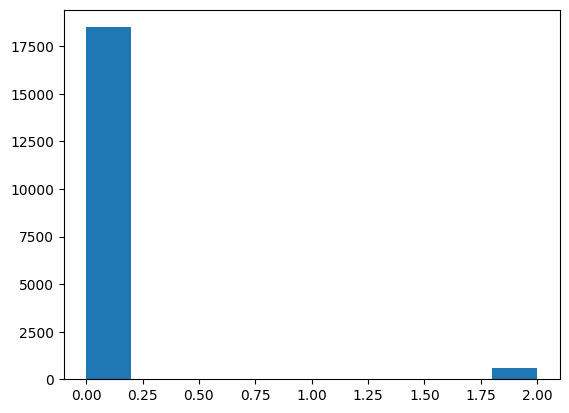

In [410]:
radian_delta = (1-np.cos(Alpha_GT - Alpha_REG))
plt.hist(radian_delta)
plt.plot()
print(radian_delta.mean())
print(radian_delta.max())

In [411]:
max_idx = np.where(radian_delta == radian_delta.max())[0][0]
print(Alpha_GT[max_idx])
print(Alpha_REG[max_idx])

-1.51
1.631572


In [418]:
print(Alpha_GT[max_idx])
print(depth_GT[max_idx])
print('GT alpha')
print(calc_depth_with_alpha_theta(IMG_W[max_idx], BOX2Ds[max_idx], CAM[max_idx], DIM_GT[max_idx][1], DIM_GT[max_idx][2], Alpha_GT[max_idx], TRUNCATEDs[max_idx]))
print('REG alpha')
print(calc_depth_with_alpha_theta(IMG_W[max_idx], BOX2Ds[max_idx], CAM[max_idx], DIM_GT[max_idx][1], DIM_GT[max_idx][2], Alpha_GT[max_idx]+0.07, TRUNCATEDs[max_idx]))

-1.51
40.99
GT alpha
40.73253649549734
REG alpha
46.941765105712726


In [405]:
print(dim_gt[1], dim_gt[2])

1.56 4.08


In [69]:
print(depth_W_GT[:20])
print(depth_W[:20])

[59.45014993 34.07181707 11.73868168 38.40881382 51.46045647 31.90104884
 20.11304859 39.18915677 24.23409767 47.90959162 61.61231115  7.71389245
 14.39797917 33.4362789  19.78650277 24.06628866 69.6762475  11.6145346
 16.1488987  23.95815037]
[57.07036805 27.91338194 11.90904911 37.95768479 57.64307585 23.89386906
 22.30641019 35.55363494 23.83529919 51.76439445 61.52170301  7.61619586
 12.86343196 27.66182235 19.13104261 21.29364123 74.26851543 11.17236168
 16.18445746 23.09508821]


In [95]:
large_idx = np.array([1,4,5,7,9,12,13,15,16])

In [402]:
print(Alpha_GT[large_idx])
print(Alpha_REG[large_idx])
print((Alpha_GT[large_idx] - Alpha_REG[large_idx])*180/np.pi)

TypeError: only integer scalar arrays can be converted to a scalar index

In [112]:
print(Dim_GT[large_idx] - Dim_REG[large_idx])

[[-0.11266037 -0.04507118  0.09808223]
 [-0.10013493  0.13550494 -0.99848109]
 [ 0.14108546  0.02386729  0.12686823]
 [ 0.14878839  0.04871505  0.28087215]
 [-0.09541136 -0.08635528 -0.044276  ]
 [-0.04600539  0.04078437  0.21999673]
 [ 0.10170231  0.01504478 -0.26026581]
 [ 0.1378584   0.07999014  0.12673943]
 [-0.0713496  -0.10199367 -0.57571523]]


In [97]:
print(Dim_GT[large_idx])
print(Dim_REG[large_idx])

[[1.41 1.58 4.36]
 [1.38 1.8  3.41]
 [1.67 1.64 4.32]
 [1.68 1.67 4.29]
 [1.4  1.51 3.7 ]
 [1.47 1.6  3.66]
 [1.7  1.63 4.08]
 [1.61 1.66 3.2 ]
 [1.41 1.53 3.37]]
[[1.52266037 1.62507118 4.26191777]
 [1.48013493 1.66449506 4.40848109]
 [1.52891454 1.61613271 4.19313177]
 [1.53121161 1.62128495 4.00912785]
 [1.49541136 1.59635528 3.744276  ]
 [1.51600539 1.55921563 3.44000327]
 [1.59829769 1.61495522 4.34026581]
 [1.4721416  1.58000986 3.07326057]
 [1.4813496  1.63199367 3.94571523]]


In [165]:
import torch.nn.functional as F
import torch
for idx in large_idx:
    print(F.mse_loss(torch.Tensor(Dim_GT[idx]), torch.Tensor(Dim_REG[idx])).item())

0.008114653639495373
0.3417843282222748
0.012190095148980618
0.03446679934859276
0.006173649337142706
0.017392834648489952
0.026102671399712563
0.013822086155414581
0.11564719676971436


In [166]:
for idx in large_idx:
    print(F.l1_loss(torch.Tensor(Dim_GT[idx]), torch.Tensor(Dim_REG[idx])).item())

0.08527135848999023
0.4113736152648926
0.09727362543344498
0.15945856273174286
0.07534758001565933
0.1022622212767601
0.12567098438739777
0.11486268043518066
0.24968619644641876


In [256]:
def L1_loss_alpha(input, target, alpha, device='cuda:0'):
    weights = [torch.ones(input.shape[0]).to(device), 1+torch.sin(alpha)**2, 1+torch.cos(alpha)**2]
    weights = torch.stack(weights, dim=1).to(device)
    loss = abs(input-target)
    loss *= weights
    return torch.mean(loss)

print(L1_loss_alpha(torch.Tensor(Dim_GT[large_idx]), torch.Tensor(Dim_REG[large_idx]), torch.Tensor(Alpha_GT[large_idx])))
print(F.l1_loss(torch.Tensor(Dim_GT[large_idx]), torch.Tensor(Dim_REG[large_idx]), reduction='mean'))

tensor(0.1859)
tensor(0.1579)


In [252]:
input_ = torch.Tensor(Dim_GT[large_idx])
target = torch.Tensor(Dim_REG[large_idx])
alphas_ = torch.Tensor(Alpha_GT[large_idx])
weights = [torch.ones(input_.shape[0]), 1+torch.sin(alphas_)**2, 1+torch.cos(alphas_)**2]
weights = torch.stack(weights, dim=1)
delta = abs(input_-target)
print(delta)
print('W')
print(weights)
print('CALC')
print(delta*weights)
print(torch.mean(delta*weights))

tensor([[0.1127, 0.0451, 0.0981],
        [0.1001, 0.1355, 0.9985],
        [0.1411, 0.0239, 0.1269],
        [0.1488, 0.0487, 0.2809],
        [0.0954, 0.0864, 0.0443],
        [0.0460, 0.0408, 0.2200],
        [0.1017, 0.0150, 0.2603],
        [0.1379, 0.0800, 0.1267],
        [0.0713, 0.1020, 0.5757]])
W
tensor([[1.0000, 1.9902, 1.0098],
        [1.0000, 1.9074, 1.0926],
        [1.0000, 1.8754, 1.1246],
        [1.0000, 1.7874, 1.2126],
        [1.0000, 1.9807, 1.0193],
        [1.0000, 1.9431, 1.0569],
        [1.0000, 1.9716, 1.0284],
        [1.0000, 1.9950, 1.0050],
        [1.0000, 1.9569, 1.0431]])
CALC
tensor([[0.1127, 0.0897, 0.0990],
        [0.1001, 0.2585, 1.0909],
        [0.1411, 0.0448, 0.1427],
        [0.1488, 0.0871, 0.3406],
        [0.0954, 0.1710, 0.0451],
        [0.0460, 0.0792, 0.2325],
        [0.1017, 0.0297, 0.2676],
        [0.1379, 0.1596, 0.1274],
        [0.0713, 0.1996, 0.6005]])
tensor(0.1859)


In [141]:
print(calc_depth_with_alpha_theta(img_W, box_2d, cam_to_img, Dim_GT[4][1], Dim_GT[4][2], alpha, 0))
print(calc_depth_with_alpha_theta(img_W, box_2d, cam_to_img, Dim_GT[4][1], Dim_GT[4][2]+1, alpha, 0))
print(calc_depth_with_alpha_theta(img_W, box_2d, cam_to_img, Dim_GT[4][1]+1, Dim_GT[4][2], alpha, 0))

tensor(36.2888)
tensor(38.6523)
tensor(51.9718)


### Cond pkl (depth_bin32_group_cond_epoch_100)

In [40]:
# all objects
DELTA_ORG = np.array(DELTA_ORG)
DELTA_NEW = np.array(DELTA_NEW)

print(abs(DELTA_ORG).mean())
print(abs(DELTA_NEW).mean())
print(len(DELTA_ORG))

2.9433497171688714
3.0952088386106587
40570


In [49]:
# all objects truncate<=0.3, occuluded<=1
DELTA_ORG = np.array(DELTA_ORG)
DELTA_NEW = np.array(DELTA_NEW)

print(abs(DELTA_ORG).mean())
print(abs(DELTA_NEW).mean())
print(len(DELTA_ORG))

2.428124641751901
3.143497436865388
27237


In [52]:
# Cars truncate<=0.3, occuluded<=1
DELTA_ORG = np.array(DELTA_ORG)
DELTA_NEW = np.array(DELTA_NEW)

print(abs(DELTA_ORG).mean())
print(abs(DELTA_NEW).mean())
print(len(DELTA_ORG))

2.1461617629105847
2.2121288069672596
19250


### No cond pkl (depth_bin32_group_epoch_100) 沒有cond的效果目前比較好

In [54]:
# Cars truncate<=0.3, occuluded<=1
DELTA_ORG = np.array(DELTA_ORG)
DELTA_NEW = np.array(DELTA_NEW)

print(abs(DELTA_ORG).mean())
print(abs(DELTA_NEW).mean())
print(len(DELTA_ORG))

1.9208071008763112
1.9307324017285972
19250


In [67]:
# Cars truncate<=0.3, occuluded<=1
DELTA_ORG = np.array(DELTA_ORG)
DELTA_NEW = np.array(DELTA_NEW)
DELTA_NEW_GT_Alpha = np.array(DELTA_NEW_GT_Alpha)
DELTA_NEW_GT_W = np.array(DELTA_NEW_GT_W)
DELTA_NEW_GT_L = np.array(DELTA_NEW_GT_L)
DELTA_NEW_GT_Dim = np.array(DELTA_NEW_GT_Dim)
DELTA_NEW_GT_All = np.array(DELTA_NEW_GT_All)

print(f'org calc: {abs(DELTA_ORG).mean():.3f}')
print(f'regress: {abs(DELTA_NEW).mean():.3f}') # 全部都用regressed value
print(f'GT alpha: {abs(DELTA_NEW_GT_Alpha).mean():.3f}') # GT alpha
print(f'GT W: {abs(DELTA_NEW_GT_W).mean():.3f}') # GT dim W
print(f'GT L: {abs(DELTA_NEW_GT_L).mean():.3f}') # GT dim L
print(f'GT dim: {abs(DELTA_NEW_GT_Dim).mean():.3f}') # GT W, L
print(f'GT all: {abs(DELTA_NEW_GT_All).mean():.3f}') #如果是用計算的dim, alpha 會GT會精準很多 (受到很多其他影響)
print(len(DELTA_ORG))

org calc: 1.921
regress: 1.931
GT alpha: 1.401
GT W: 1.575
GT L: 1.692
GT dim: 1.363
GT all: 0.341
19250


# 0613 Dimension loss comparation

In [309]:
from torchvision.models import vgg
from torch_lib.Model_heading_bin_no_bias import *
from torch_lib.ClassAverages import *
from torchvision import transforms
import os, glob, cv2
from library.ron_utils import *
import matplotlib.pyplot as plt

cuda = 0
#pred_label_root = '0606_depth_bias'
bin_num=32
angle_per_class = 2*np.pi/float(bin_num)

W_MSE = 'weights/mse_loss_epoch_20.pkl'
W_L1 = 'weights/L1_loss_epoch_20.pkl'
W_AL1 = 'weights/Alpha_L1_loss_epoch_20.pkl'
device = 'cuda:0'
#os.makedirs(pred_label_root, exist_ok=True)
my_vgg = vgg.vgg19_bn(pretrained=True)
model_MSE = Model(features=my_vgg.features, bins=bin_num).to(device)
#因為train的時候在不同GPU上，eval要map到同個GPU https://www.jianshu.com/p/ec91b3b59f66
model_MSE.load_state_dict(torch.load(W_MSE, map_location=device)['model_state_dict'])
model_MSE.eval()

model_L1 = Model(features=my_vgg.features, bins=bin_num).to(device)
model_L1.load_state_dict(torch.load(W_L1, map_location=device)['model_state_dict'])
model_L1.eval()

model_AL1 = Model(features=my_vgg.features, bins=bin_num).to(device)
model_AL1.load_state_dict(torch.load(W_AL1, map_location=device)['model_state_dict'])
model_AL1.eval()
# for img processing
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
process = transforms.Compose([transforms.ToTensor(), normalize])

img_root = "./Kitti/training/image_2"
label_root = "./Kitti/training/label_2"
calib_root = "./Kitti/training/calib"
extra_label_root = "./Kitti/training/extra_label"
images = glob.glob(os.path.join(img_root, '*.png'), recursive=True)
labels = glob.glob(os.path.join(label_root, '*.txt'), recursive=True)
calibs = glob.glob(os.path.join(calib_root, '*.txt'), recursive=True)
extra = glob.glob(os.path.join(extra_label_root, '*.txt'), recursive=True)

ImageSets_root = './Kitti/ImageSets'
split = 'trainval'
split_dir = os.path.join(ImageSets_root, split + '.txt')
ids = [int(x.strip()) for x in open(split_dir).readlines()]

# dim averages
averages_all = ClassAverages()

depth_GT = list()
imgW_GT = list()
Trun_GT = list()
BOX2D_GT = list()
Alpha_GT = list()
DIM_GT = list()  
DIM_REG_MSE = list()
DIM_REG_L1 = list()
DIM_REG_AL1 = list()
CAM = list()
for i in ids:
    img = cv2.imread(images[i])
    imgW = img.shape[1] # H,W,3
    cam_to_img = get_calibration_cam_to_image(calibs[i])
    extra_labels = get_extra_labels(extra[i])
    CROPs_tensor = list()
    with open(labels[i]) as f:
        lines = f.readlines()

    for idx, line in enumerate(lines):
        elements = line[:-1].split()
        
        for j in range(1, len(elements)):
            elements[j] = float(elements[j])
        
        truncate = elements[1] # 0~1
        occluded = int(elements[2]) # 0:visible, 1:partly, 2:largely, 3:unknown
        
        if elements[0] != 'Car' or truncate>0.3 or occluded>1:
            continue
        CAM.append(cam_to_img)
        imgW_GT.append(imgW)
        Trun_GT.append(truncate)
        top_left = (int(round(elements[4])), int(round(elements[5])))
        btm_right = (int(round(elements[6])), int(round(elements[7])))
        box_2d = [top_left, btm_right]
        BOX2D_GT.append(box_2d)

        dim = np.array([elements[8], elements[9], elements[10]], dtype=np.double) # Height, Width, Length
        DIM_GT.append(dim)
        alpha = elements[3]
        Alpha_GT.append(alpha)
        #cv2 is(H,W,3)
        crop = img[top_left[1]:btm_right[1]+1, top_left[0]:btm_right[0]+1] 
        crop = cv2.resize(src = crop, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        crop = process(crop) # expand to 224x224
        theta_ray = extra_labels[idx]['Theta_ray']
        THETAs.append(theta_ray)
        depth_label = elements[13]
        depth_GT.append(depth_label)
        CROPs_tensor.append(crop)
        '''
        d2_center = get_box_center(box_2d)
        cv2.rectangle(img, box_2d[0], box_2d[1], color=(255,0,0), thickness=2)
        cv2.putText(img, f'{idx}', (d2_center[0], d2_center[1]+10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 1, cv2.LINE_AA)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    
    '''
    if len(CROPs_tensor) == 0:
        continue
    # put together as a batch
    input_ = torch.stack(CROPs_tensor).to(device)
    
    # MSE model regress
    [RESIDUALs, BIN_CONFs, delta_MSE] = model_MSE(input_)
    [RESIDUALs, BIN_CONFs, delta_L1] = model_L1(input_)
    [RESIDUALs, BIN_CONFs, delta_AL1] = model_AL1(input_)

    for mse, l1, al1 in zip(delta_MSE, delta_L1, delta_AL1):
        mse = mse.cpu().data.numpy() #torch->numpy
        l1 = l1.cpu().data.numpy() #torch->numpy
        al1 = al1.cpu().data.numpy() #torch->numpy
        DIM_REG_MSE.append(mse + averages_all.get_item('Car'))
        DIM_REG_L1.append(l1 + averages_all.get_item('Car'))
        DIM_REG_AL1.append(al1 + averages_all.get_item('Car'))
        #calc_depth_with_alpha_theta(img_W, box_2d, cam_to_img, dim[1], dim[2], alpha, trun)
    
    if i%500==0:
        print(i)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


In [310]:
DIM_GT = np.array(DIM_GT)
DIM_REG_MSE = np.array(DIM_REG_MSE)
DIM_REG_L1 = np.array(DIM_REG_L1)
DIM_REG_AL1 = np.array(DIM_REG_AL1)
depth_GT = np.array(depth_GT)

In [311]:
calc_depth_GT = list()
calc_depth_MSE = list()
calc_depth_L1 = list()
calc_depth_AL1 = list()
for cam_to_img, imgW, trun, box_2d, alpha, dim_gt, dim_mse, dim_l1, dim_al1 in zip(CAM, imgW_GT, Trun_GT, BOX2D_GT, Alpha_GT, DIM_GT, DIM_REG_MSE, DIM_REG_L1, DIM_REG_AL1):
    calc_depth_GT.append(calc_depth_with_alpha_theta(imgW, box_2d, cam_to_img, dim_gt[1], dim_gt[2], alpha, trun))
    calc_depth_MSE.append(calc_depth_with_alpha_theta(imgW, box_2d, cam_to_img, dim_mse[1], dim_mse[2], alpha, trun))
    calc_depth_L1.append(calc_depth_with_alpha_theta(imgW, box_2d, cam_to_img, dim_l1[1], dim_l1[2], alpha, trun))
    calc_depth_AL1.append(calc_depth_with_alpha_theta(imgW, box_2d, cam_to_img, dim_al1[1], dim_al1[2], alpha, trun))
calc_depth_GT = np.array(calc_depth_GT)
calc_depth_MSE = np.array(calc_depth_MSE)
calc_depth_L1 = np.array(calc_depth_L1)
calc_depth_AL1 = np.array(calc_depth_AL1)

In [330]:
def box_depth_error_calculation(depth_labels, depth_Calcs, out_range=10):
    class_GT = np.copy(depth_labels) #28742 car
    print(f'num of Car:', class_GT.shape[0])
    class_cal = np.copy(depth_Calcs)
    for depth in [0, 10, 20, 30, 40, 50]:
        class_GT_depth = class_GT[np.logical_and(class_GT >= depth, class_GT < depth+10.)]
        print(f'\tnum of depth {depth}-{depth+10}:', class_GT_depth.shape[0], end=' ')
        class_cal_depth = class_cal[np.logical_and(class_GT >= depth, class_GT < depth+10.)]
        cal_delta = abs(class_GT_depth - class_cal_depth)
        #cal_delta, _, out_indexes = filter_out_of_range(cal_delta, out_range) # remove prediction out of 10
        print(f'\tabs_delta mean:{cal_delta.mean():.3f}m, Out of {out_range}m: {cal_delta[cal_delta>=out_range].shape[0]}')

    # after 60 m
    class_GT_depth = class_GT[class_GT >= 60.]
    print(f'\tnum of depth {depth+10}+:', class_GT_depth.shape[0], end='   ')
    class_cal_depth = class_cal[class_GT >= 60.]
    cal_delta = abs(class_GT_depth - class_cal_depth)
    #cal_delta, _, out_indexes = filter_out_of_range(cal_delta, out_range) # remove prediction out of 10
    print(f'\tabs_delta mean:{cal_delta.mean():.3f}m, Out of {out_range}m: {cal_delta[cal_delta>=out_range].shape[0]}')
    
    total = abs(class_GT-class_cal)
    print(f'[Total] mean:{total.mean():.3f}, std:{total.std():.3f}')

In [335]:
box_depth_error_calculation(depth_GT, calc_depth_GT, out_range=5)

num of Car: 19250
	num of depth 0-10: 1321 	abs_delta mean:0.664m, Out of 5m: 0
	num of depth 10-20: 4479 	abs_delta mean:0.254m, Out of 5m: 0
	num of depth 20-30: 4357 	abs_delta mean:0.375m, Out of 5m: 0
	num of depth 30-40: 3600 	abs_delta mean:0.442m, Out of 5m: 0
	num of depth 40-50: 2702 	abs_delta mean:0.575m, Out of 5m: 0
	num of depth 50-60: 1619 	abs_delta mean:0.737m, Out of 5m: 0
	num of depth 60+: 1172   	abs_delta mean:1.067m, Out of 5m: 0
[Total] mean:0.480, std:0.522


In [336]:
box_depth_error_calculation(depth_GT, calc_depth_MSE, out_range=5)

num of Car: 19250
	num of depth 0-10: 1321 	abs_delta mean:0.793m, Out of 5m: 0
	num of depth 10-20: 4479 	abs_delta mean:0.733m, Out of 5m: 3
	num of depth 20-30: 4357 	abs_delta mean:1.233m, Out of 5m: 23
	num of depth 30-40: 3600 	abs_delta mean:1.624m, Out of 5m: 100
	num of depth 40-50: 2702 	abs_delta mean:2.130m, Out of 5m: 171
	num of depth 50-60: 1619 	abs_delta mean:2.880m, Out of 5m: 264
	num of depth 60+: 1172   	abs_delta mean:3.700m, Out of 5m: 321
[Total] mean:1.574, std:1.728


In [337]:
box_depth_error_calculation(depth_GT, calc_depth_L1, out_range=5)

num of Car: 19250
	num of depth 0-10: 1321 	abs_delta mean:0.777m, Out of 5m: 0
	num of depth 10-20: 4479 	abs_delta mean:0.713m, Out of 5m: 3
	num of depth 20-30: 4357 	abs_delta mean:1.170m, Out of 5m: 15
	num of depth 30-40: 3600 	abs_delta mean:1.588m, Out of 5m: 95
	num of depth 40-50: 2702 	abs_delta mean:2.034m, Out of 5m: 153
	num of depth 50-60: 1619 	abs_delta mean:2.789m, Out of 5m: 242
	num of depth 60+: 1172   	abs_delta mean:3.631m, Out of 5m: 303
[Total] mean:1.522, std:1.708


In [338]:
box_depth_error_calculation(depth_GT, calc_depth_AL1, out_range=5)

num of Car: 19250
	num of depth 0-10: 1321 	abs_delta mean:0.778m, Out of 5m: 0
	num of depth 10-20: 4479 	abs_delta mean:0.681m, Out of 5m: 3
	num of depth 20-30: 4357 	abs_delta mean:1.125m, Out of 5m: 18
	num of depth 30-40: 3600 	abs_delta mean:1.509m, Out of 5m: 80
	num of depth 40-50: 2702 	abs_delta mean:1.944m, Out of 5m: 142
	num of depth 50-60: 1619 	abs_delta mean:2.691m, Out of 5m: 219
	num of depth 60+: 1172   	abs_delta mean:3.498m, Out of 5m: 278
[Total] mean:1.461, std:1.659


In [347]:
print('ALL')
print(abs(DIM_GT[:,:]-DIM_REG_MSE[:,:]).mean())
print(abs(DIM_GT[:,:]-DIM_REG_L1[:,:]).mean())
print(abs(DIM_GT[:,:]-DIM_REG_AL1[:,:]).mean())
print('Val')
print(abs(DIM_GT[val_ids,:]-DIM_REG_MSE[val_ids,:]).mean())
print(abs(DIM_GT[val_ids,:]-DIM_REG_L1[val_ids,:]).mean())
print(abs(DIM_GT[val_ids,:]-DIM_REG_AL1[val_ids,:]).mean())
print('Train')
print(abs(DIM_GT[train_ids,:]-DIM_REG_MSE[train_ids,:]).mean())
print(abs(DIM_GT[train_ids,:]-DIM_REG_L1[train_ids,:]).mean())
print(abs(DIM_GT[train_ids,:]-DIM_REG_AL1[train_ids,:]).mean())

ALL
0.14393166116461553
0.13814717896766388
0.134547621557227
Val
0.14448681662514817
0.13857501836045888
0.13504707924301218
Train
0.14563839353193608
0.1388124312541294
0.1352747878371857


In [343]:
print(np.linalg.norm(DIM_GT[:,:]-DIM_REG_L1[:,:]))
print(abs(DIM_GT[:,:]-DIM_REG_L1[:,:]).mean()) #-335

52.711701961317885
0.13814717896766388


In [341]:
print(np.linalg.norm(DIM_GT[:,1:]-DIM_REG_AL1[:,1:]))
print(abs(DIM_GT[:,:]-DIM_REG_AL1[:,:]).mean()) #-542 -207

48.81996391167859
0.134547621557227
